## Configuration

In [ ]:
%load_ext autoreload
%autoreload 2

import os, time, pytz, datetime
import optuna
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

from src.utils import evaluate_hitrate_at_3, make_submission
from src.feature import feature_engineering, feature_selection
from src.plot import plot_hitrate_at_k, plot_ndcg_curve
from src.data import split_dataset
from src.params import get_hyper_params
from src.utils import TRAIN_VAL_SIZE

# Configurations
MODEL = "xgboost"
# MODEL = "lightgbm"
# Switch to True when training on full dataset
FULL = True
# Switch to True when debugging the feature engineering
DEBUG = False
# Switch to True when the feature_engineering is not changed
CACHE = True if not FULL and not DEBUG else False
RANDOM_STATE = 42

try:
    TIME_TAG
except NameError:
    tz = pytz.timezone("Asia/Shanghai")
    TIME_TAG = datetime.datetime.now(tz).strftime("%Y%m%d%H%M%S")
print("Time Tag:", TIME_TAG)

DATA_DIR = "./data"
MODEL_DIR = "model"
SUBMIT_DIR = "submission"

# Create dir
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SUBMIT_DIR, exist_ok=True)

# Feature engineered df
feat_df_path = "feateng_full.parquet" if FULL else "feateng_not_full.parquet"
feat_df_path = os.path.join(DATA_DIR, feat_df_path)

/home/zhengxiang/miniconda3/envs/FlightRank/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Time Tag: 20250815181755


## Data Processing

In [2]:
# Load data
if not DEBUG:
    train = pl.read_parquet(os.path.join(DATA_DIR, "train.parquet")).drop(
        "__index_level_0__"
    )
    test = (
        pl.read_parquet(os.path.join(DATA_DIR, "test.parquet"))
        .drop("__index_level_0__")
        .with_columns(pl.lit(0, dtype=pl.Int64).alias("selected"))
    )

    val = train.slice(TRAIN_VAL_SIZE, train.height - TRAIN_VAL_SIZE)

    df = pl.concat((train, test))
else:
    train = pl.read_parquet(os.path.join(DATA_DIR, "train.parquet")).drop(
        "__index_level_0__"
    )
    unique_rankers = train["ranker_id"].unique()
    sample_ratio = 0.001
    sampled_rankers = unique_rankers.sample(fraction=sample_ratio, seed=RANDOM_STATE)
    df = train.filter(pl.col("ranker_id").is_in(sampled_rankers))

print("Successfully load parquet files!")

Successfully load parquet files!


## Feature Engineering

In [3]:
if CACHE:
    df = pl.read_parquet(feat_df_path)
else:
    df = feature_engineering(df, FULL)
print("Feature engineering finished!")

Feature engineering finished!


In [4]:
# Fill nulls
df = df.with_columns(
    [pl.col(c).fill_null(0) for c in df.select(pl.selectors.numeric()).columns]
    + [pl.col(c).fill_null("missing") for c in df.select(pl.selectors.string()).columns]
    + [pl.col(c).fill_null(False) for c in df.select(pl.selectors.boolean()).columns]
)

# Save for reuse
if not CACHE and not DEBUG:
    df.write_parquet(feat_df_path)

## Feature Selection

In [5]:
X, y, groups, cat_features_final, num_features_final = feature_selection(df)

Using 176 features (93 categorical, 83 numerical)


In [6]:
schema_dict = X.schema

for col, dtype in schema_dict.items():
    print(f"{col}: {dtype}")

bySelf: Boolean
corporateTariffCode: Int64
nationality: Int64
isAccess3D: Boolean
isVip: Boolean
legs0_segments0_cabinClass: Int8
legs0_segments0_flightNumber: String
legs0_segments0_arrivalTo_airport_city_iata: String
legs0_segments0_arrivalTo_airport_iata: String
legs0_segments0_departureFrom_airport_iata: String
legs0_segments0_baggageAllowance_weightMeasurementType: Float64
legs0_segments0_marketingCarrier_code: String
legs0_segments0_operatingCarrier_code: String
legs1_segments0_cabinClass: Int8
legs1_segments0_flightNumber: String
legs1_segments0_arrivalTo_airport_city_iata: String
legs1_segments0_arrivalTo_airport_iata: String
legs1_segments0_departureFrom_airport_iata: String
legs1_segments0_baggageAllowance_weightMeasurementType: Float64
legs1_segments0_marketingCarrier_code: String
legs1_segments0_operatingCarrier_code: String
pricingInfo_isAccessTP: Float64
miniRules0_statusInfos: Int32
miniRules1_statusInfos: Int32
sex: Boolean
has_ff_program: Int32
has_corporate_tariff: In

In [7]:
# combined = pl.concat([df.select("Id"), groups, X, y], how="horizontal")
# print(combined.head())
# print(f"Save feature engineered file to {feat_df_path}")
# combined.write_parquet(feat_df_path)

## Train-Val-Test Split

In [8]:
dtrain, dval, dtest, dfull, _, _, _, X_va, y_va, groups_va, X_te = split_dataset(
    train, X, y, groups, cat_features_final, MODEL
)
print("Data split finished!")

Data split finished!


In [9]:
del train, df, X
if not FULL:
    del dtest, dfull, X_te
else:
    del dtrain
import gc

gc.collect()

17

## Tune hyperparams (Optional)

In [10]:
import joblib
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

os.makedirs("optuna", exist_ok=True)
STUDY_FILENAME = f"optuna/{TIME_TAG}.pkl"


def load_or_create_study():
    try:
        study = joblib.load(STUDY_FILENAME)
        print(f"Loaded study from {STUDY_FILENAME}")
    except FileNotFoundError:
        study = optuna.create_study(
            direction="maximize",
            sampler=TPESampler(seed=RANDOM_STATE),
            pruner=SuccessiveHalvingPruner(),
        )
        print("Created new study")
    return study


def save_study(study):
    joblib.dump(study, STUDY_FILENAME)
    print(f"Saved study to {STUDY_FILENAME}")

In [11]:
# define objectives


def xgb_objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "max_depth": trial.suggest_int("max_depth", 10, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 20, 50),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.7),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1, 100, log=True),
        "alpha": trial.suggest_float("alpha", 1e-2, 100, log=True),
        # "sampling_method": trial.suggest_categorical(
        #     "sampling_method", ["uniform", "gradient_based"]
        # ),
        "objective": "rank:pairwise",
        "eval_metric": "ndcg@3",
        "seed": RANDOM_STATE,
        "n_jobs": 32,
        "device": "cuda",
        "tree_method": "gpu_hist",
    }

    num_boost_round = trial.suggest_int("num_boost_round", 500, 1500)

    evals_result = {}
    model = xgb.train(
        params,
        dtrain if not FULL else dfull,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dval, "val")] if not FULL else [(dfull, "train")],
        early_stopping_rounds=100,
        verbose_eval=150,
        maximize=True,
        evals_result=evals_result,
    )

    ndcg = model.best_score
    trial.set_user_attr("best_ndcg@3", ndcg)

    return ndcg


def lgb_objective(trial):
    max_depth = trial.suggest_int("max_depth", 10, 15)
    num_leaves = trial.suggest_int("num_leaves", 1024, 10000)
    param = {
        "objective": "lambdarank",
        "metric": "ndcg",
        "ndcg_eval_at": [3],
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "feature_fraction": trial.suggest_float("feature_fraction", 0.3, 0.8),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 1500),
        "min_sum_hessian_in_leaf": trial.suggest_float(
            "min_sum_hessian_in_leaf", 1e-2, 100.0, log=True
        ),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.4, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1, 100, log=True),
        "path_smooth": trial.suggest_float("path_smooth", 1.0, 5.0),
        "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
        "boost_from_average": False,
        "use_missing": True,
        # "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "goss"]),
        "n_jobs": 32,
        "verbosity": -1,
        # "device": "gpu",
        "seed": RANDOM_STATE,
    }

    num_boost_round = trial.suggest_int("num_boost_round", 500, 1500)

    evals_result = {}
    model = lgb.train(
        param,
        dtrain,
        num_boost_round=num_boost_round,
        valid_sets=[dtrain, dval],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=150),
            lgb.record_evaluation(evals_result),
        ],
    )

    best_iter = model.best_iteration
    best_ndcg3 = evals_result["valid"]["ndcg@3"][best_iter - 1]

    trial.set_user_attr("best_iteration", best_iter)
    trial.set_user_attr("best_ndcg@3", best_ndcg3)

    print(
        f"Trial {trial.number}: best_iteration={best_iter}, best_ndcg@3={best_ndcg3:.6f}"
    )

    return best_ndcg3

In [12]:
# study = load_or_create_study()
# n_trials = 50
# for _ in range(n_trials):
#     study.optimize(xgb_objective, n_trials=1)
#     save_study(study)

# best_params = study.best_params
# best_params.update(
#     {
#         "objective": "rank:pairwise",
#         "eval_metric": "ndcg@3",
#         "seed": RANDOM_STATE,
#         "n_jobs": 32,
#         "device": "cuda",
#         "tree_method": "gpu_hist",
#     }
# )

In [13]:
best_params = get_hyper_params(MODEL)

In [14]:
print("Best params:", best_params)

Best params: {'learning_rate': 0.02040679350169802, 'max_depth': 13, 'min_child_weight': 28, 'subsample': 0.9909028321076129, 'colsample_bytree': 0.6958881457869247, 'gamma': 3.5134961637899917, 'lambda': 3.7060709419160025, 'alpha': 0.011070984915230472, 'num_boost_round': 1499, 'objective': 'rank:pairwise', 'eval_metric': 'ndcg@3', 'seed': 42, 'n_jobs': 32, 'device': 'cuda', 'tree_method': 'gpu_hist'}


## Model Training

In [15]:
print(f"Training final {MODEL} model...")
if MODEL == "xgboost":
    evals_result = {}
    model = xgb.train(
        best_params,
        dtrain if not FULL else dfull,
        num_boost_round=1200,
        evals=[(dtrain, "train"), (dval, "val")] if not FULL else [(dfull, "train")],
        verbose_eval=50,
        maximize=True,
        evals_result=evals_result,
    )
elif MODEL == "lightgbm":
    model = lgb.train(
        best_params,
        dtrain if not FULL else dfull,
        valid_sets=[dtrain, dval] if not FULL else [dfull],
        callbacks=[lgb.log_evaluation(50), lgb.callback.record_evaluation({})],
    )

Training final xgboost model...


[0]	train-ndcg@3:0.38321	val-ndcg@3:0.40028
[50]	train-ndcg@3:0.59986	val-ndcg@3:0.47762
[100]	train-ndcg@3:0.65289	val-ndcg@3:0.48669
[150]	train-ndcg@3:0.68937	val-ndcg@3:0.49145
[200]	train-ndcg@3:0.71508	val-ndcg@3:0.49744
[250]	train-ndcg@3:0.73690	val-ndcg@3:0.50057
[300]	train-ndcg@3:0.75629	val-ndcg@3:0.50496
[350]	train-ndcg@3:0.77714	val-ndcg@3:0.50565
[400]	train-ndcg@3:0.79214	val-ndcg@3:0.50639
[450]	train-ndcg@3:0.80653	val-ndcg@3:0.50867
[500]	train-ndcg@3:0.81751	val-ndcg@3:0.50947
[550]	train-ndcg@3:0.83099	val-ndcg@3:0.51229
[600]	train-ndcg@3:0.84329	val-ndcg@3:0.51239
[650]	train-ndcg@3:0.85650	val-ndcg@3:0.51257
[700]	train-ndcg@3:0.86864	val-ndcg@3:0.51381
[750]	train-ndcg@3:0.87819	val-ndcg@3:0.51425
[800]	train-ndcg@3:0.88553	val-ndcg@3:0.51424
[850]	train-ndcg@3:0.89177	val-ndcg@3:0.51522
[900]	train-ndcg@3:0.89778	val-ndcg@3:0.51515
[950]	train-ndcg@3:0.90225	val-ndcg@3:0.51662
[1000]	train-ndcg@3:0.90601	val-ndcg@3:0.51681
[1050]	train-ndcg@3:0.90848	val-ndcg

In [16]:
# Save model
if FULL:
    model_path = os.path.join(MODEL_DIR, f"{MODEL}_{TIME_TAG}.json")
    model.save_model(model_path)
    print(f"Model saved to: {model_path}")

In [28]:
# Evaluate
if MODEL == "xgboost":
    va_preds = evaluate_hitrate_at_3(val, dval, y_va, groups_va, model, False)
elif MODEL == "lightgbm":
    va_preds = evaluate_hitrate_at_3(val, X_va, y_va, groups_va, model, True)
else:
    raise ValueError(f"Unsupported model {MODEL}")

shape: (5, 3)
┌──────────┬─────────────────────────────────┬──────────┐
│ Id       ┆ ranker_id                       ┆ selected │
│ ---      ┆ ---                             ┆ ---      │
│ i64      ┆ str                             ┆ i32      │
╞══════════╪═════════════════════════════════╪══════════╡
│ 16487352 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 6        │
│ 16487353 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 3        │
│ 16487354 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 10       │
│ 16487355 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 5        │
│ 16487356 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 1        │
└──────────┴─────────────────────────────────┴──────────┘
HitRate@3: 0.55145


In [18]:
# from src.utils import hitrate_at_3_verbose

# xgb_va_preds = model.predict(dval)
# xgb_hr3, featured_va_df = hitrate_at_3_verbose(
#     y_va, xgb_va_preds, groups_va, features_df=X_va
# )
# print(f"HitRate@3: {xgb_hr3:.5f}")

In [19]:
if MODEL == "xgboost":
    importance = model.get_score(importance_type="gain")
    importance_df = pl.DataFrame(
        [{"feature": k, "importance": v} for k, v in importance.items()]
    ).sort("importance", descending=bool(1))

elif MODEL == "lightgbm":
    importance = model.feature_importance(importance_type="gain")
    feature_names = model.feature_name()
    importance_df = pl.DataFrame(
        {"feature": feature_names, "importance": importance}
    ).sort("importance", descending=True)

print(importance_df.to_pandas().to_string())

                                                         feature   importance
0                                           is_min_segments_leg0  3643.326172
1                                                 is_direct_leg0   442.539551
2                                                  free_exchange   282.833618
3                                                n_segments_leg1   191.782883
4                                        legs0_all_cabin_level_1   113.650558
5                                          legs0_max_cabin_level    86.500420
6                                         global_max_cabin_level    75.979317
7                                       is_direct_cheapest_legs0    74.641983
8                                         pricingInfo_isAccessTP    67.118980
9                                         legs0_is_cross_country    56.938366
10                                         avg_cabin_class_legs0    55.035194
11                                      legs0_segments1_duration

## Error analysis and Visualization

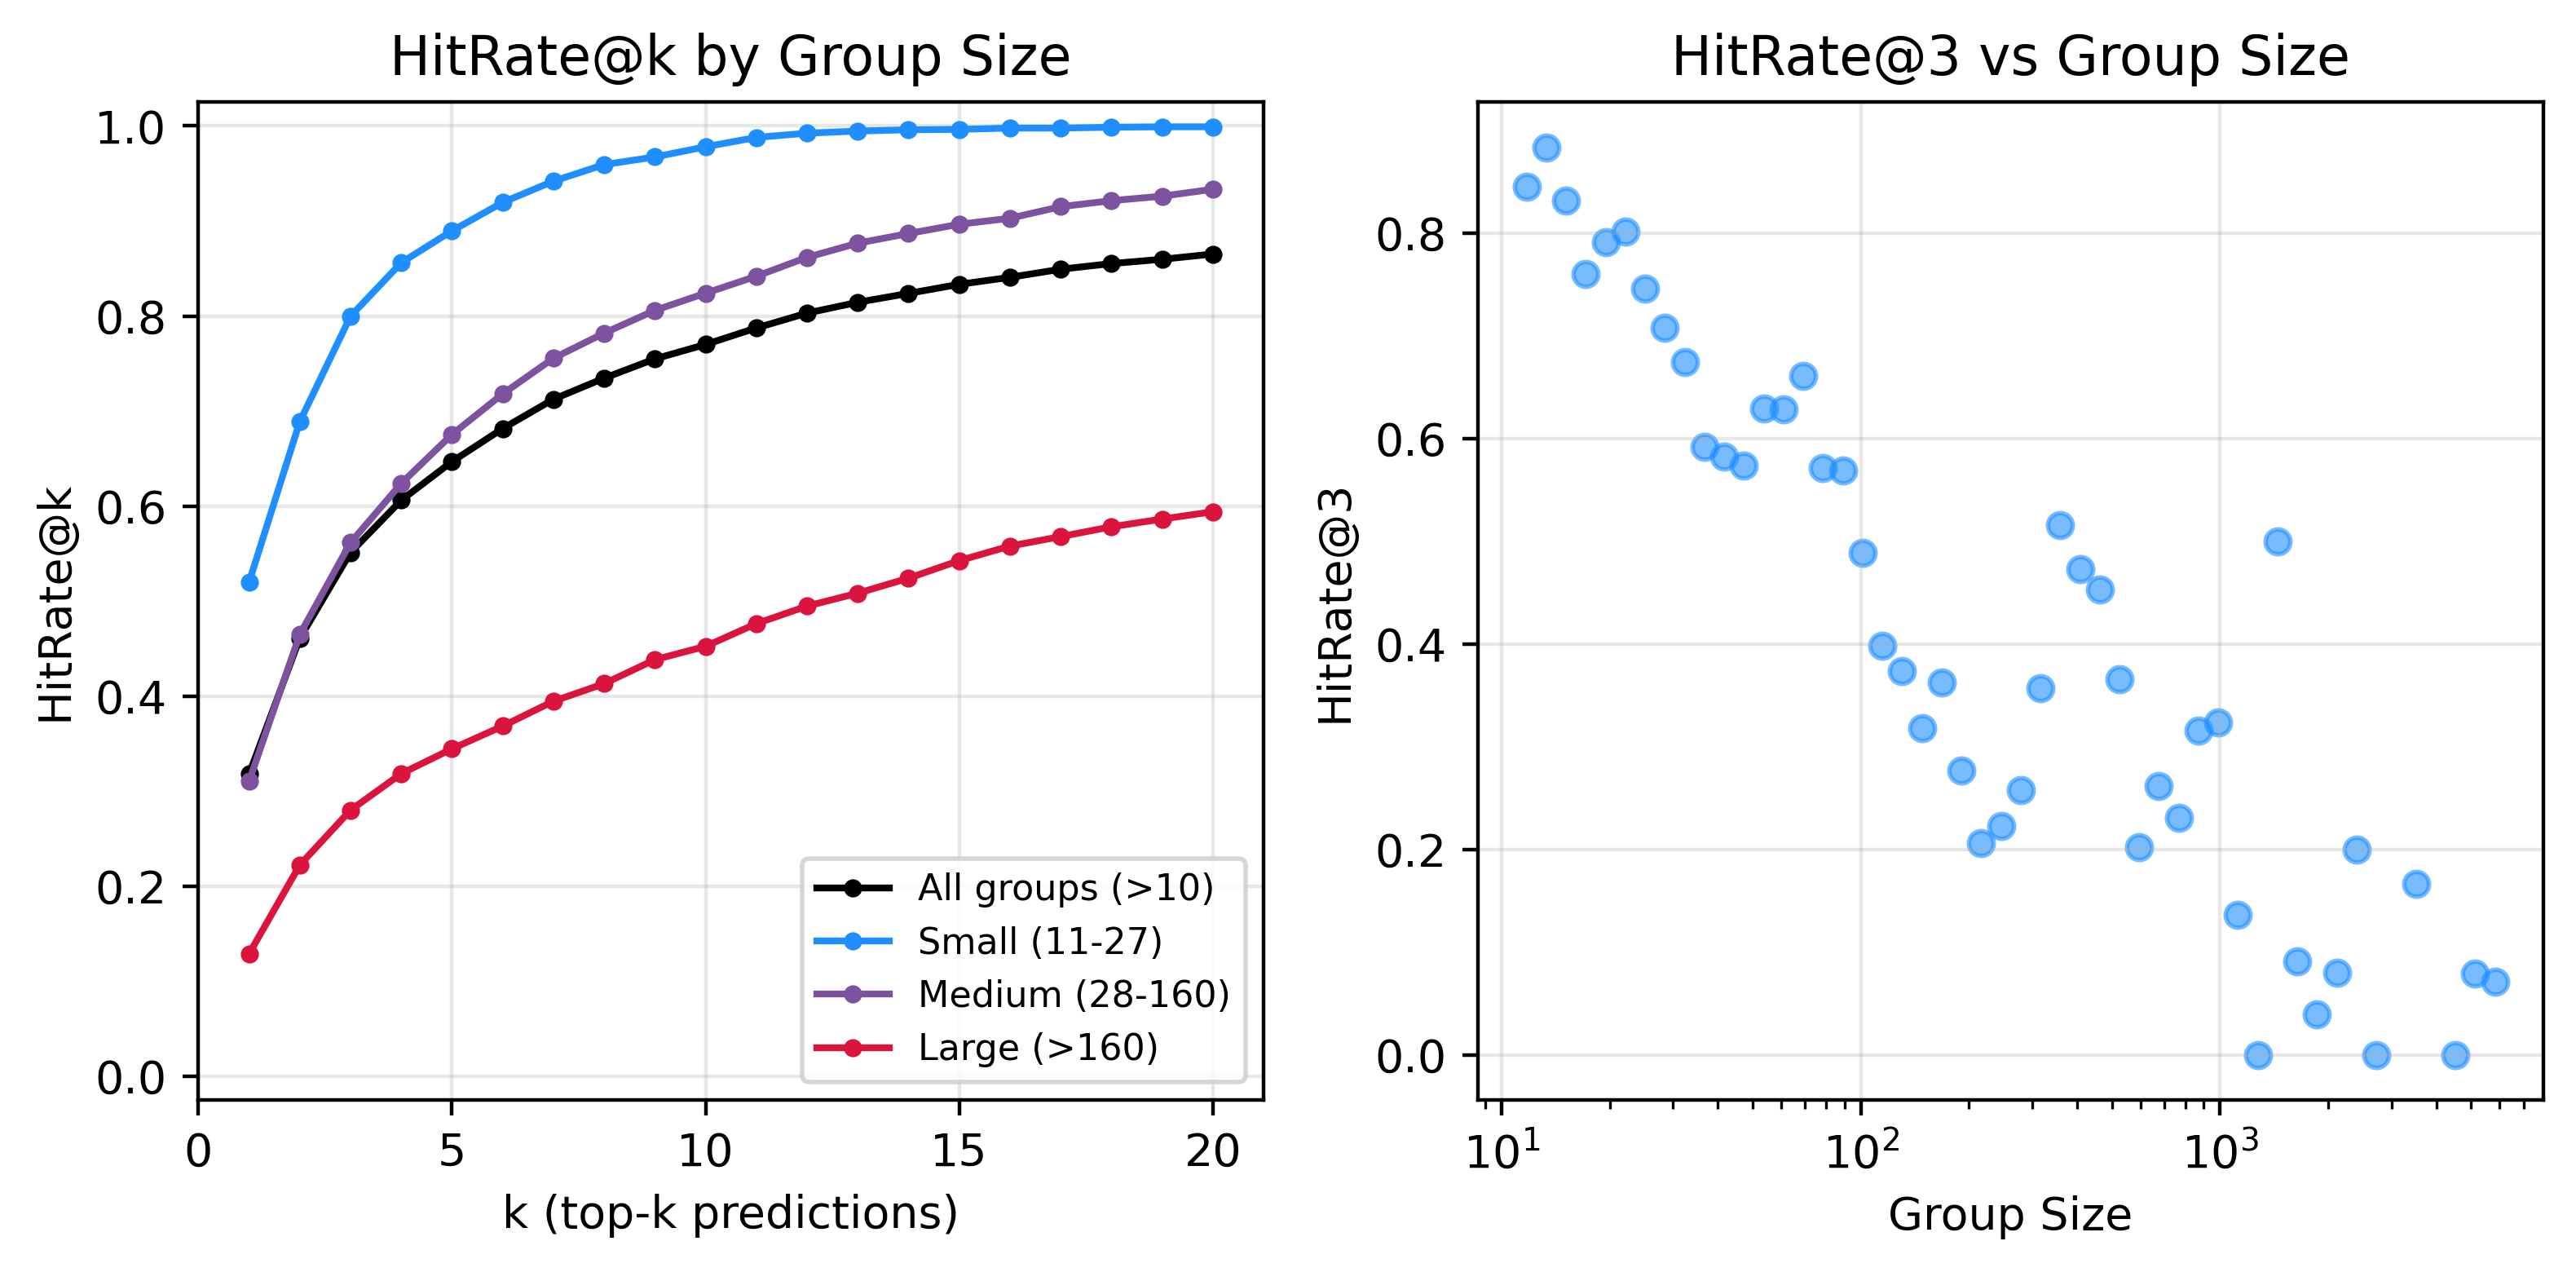

In [20]:
curves = plot_hitrate_at_k(groups_va, va_preds, y_va)

In [21]:
# Summary
print(f"HitRate@1: {curves['All groups (>10)'][0]:.5f}")
print(f"HitRate@3: {curves['All groups (>10)'][2]:.5f}")
print(f"HitRate@4: {curves['All groups (>10)'][3]:.5f}")
print(f"HitRate@5: {curves['All groups (>10)'][4]:.5f}")
print(f"HitRate@6: {curves['All groups (>10)'][5]:.5f}")
print(f"HitRate@10: {curves['All groups (>10)'][9]:.5f}")
print(f"HitRate@20: {curves['All groups (>10)'][19]:.5f}")

HitRate@1: 0.31806
HitRate@3: 0.55123
HitRate@4: 0.60617
HitRate@5: 0.64681
HitRate@6: 0.68160
HitRate@10: 0.77010
HitRate@20: 0.86523


## Submission

In [22]:
if FULL:
    submission_path = os.path.join(SUBMIT_DIR, f"submission_{TIME_TAG}.parquet")
    score_path = os.path.join(SUBMIT_DIR, "score", f"{TIME_TAG}.parquet")
    if MODEL == "xgboost":
        make_submission(test, dtest, model, submission_path, rerank=False)
        make_submission(test, dtest, model, score_path, True, False)
    elif MODEL == "lightgbm":
        make_submission(test, X_te, model, submission_path, rerank=True)
        make_submission(test, X_te, model, score_path, True, True)

In [23]:
# !kaggle competitions submit -c aeroclub-recsys-2025 -f {submission_file} -m {TIME_TAG}